In [42]:
from IPython.display import Image

In [13]:
from pydantic import BaseModel, Field
from typing import  Literal
from langchain_core.tools import tool
from langchain_openai import ChatOpenAI
from langgraph.graph import MessagesState

In [17]:
from dotenv import load_dotenv
assert load_dotenv()

In [44]:
Image(url='./react-output.png', width=500)

- 增加一个 respond 节点，做结构化的输出处理；

In [2]:
class WeatherResponse(BaseModel):
    """Respond to the user with this"""
    temperature: float = Field(description="The temperature in fahrenheit")
    wind_directon: str = Field(description="The direction of the wind in abbreviated form")
    wind_speed: float = Field(description="The speed of the wind in km/h")

In [3]:
# Inherit 'messages' key from MessagesState, which is a list of chat messages 
class AgentState(MessagesState):
    # Final structured response from the agent
    final_response: WeatherResponse

In [11]:
from typing import get_type_hints

In [12]:
get_type_hints(AgentState)

{'messages': list[typing.Union[langchain_core.messages.ai.AIMessage, langchain_core.messages.human.HumanMessage, langchain_core.messages.chat.ChatMessage, langchain_core.messages.system.SystemMessage, langchain_core.messages.function.FunctionMessage, langchain_core.messages.tool.ToolMessage]],
 'final_response': __main__.WeatherResponse}

In [14]:
@tool
def get_weather(city: Literal["nyc", "sf"]):
    """Use this to get weather information."""
    if city == "nyc":
        return "It is cloudy in NYC, with 5 mph winds in the North-East direction and a temperature of 70 degrees"
    elif city == "sf":
        return "It is 75 degrees and sunny in SF, with 3 mph winds in the South-East direction"
    else:
        raise AssertionError("Unknown city")

In [15]:
tools = [get_weather]

In [18]:
model = ChatOpenAI(model="gpt-3.5-turbo")

In [20]:
model_w_tools = model.bind_tools(tools)
model_w_output = model.with_structured_output(WeatherResponse)

### bind output as tool

In [21]:
from langgraph.graph import StateGraph, END
from langgraph.prebuilt import ToolNode

tools = [get_weather, WeatherResponse]

In [23]:
# Force the model to use tools by passing tool_choice="any"    
model_with_response_tool = model.bind_tools(tools, tool_choice="any")

In [24]:
# Define the function that calls the model
def call_model(state: AgentState):
    response = model_with_response_tool.invoke(state['messages'])
    # We return a list, because this will get added to the existing list
    return {"messages": [response]}

In [25]:
# Define the function that responds to the user
def respond(state: AgentState):
    # Construct the final answer from the arguments of the last tool call
    response = WeatherResponse(**state['messages'][-1].tool_calls[0]['args'])
    # We return the final answer
    return {"final_response": response}

In [26]:
# Define the function that determines whether to continue or not
def should_continue(state: AgentState):
    messages = state["messages"]
    last_message = messages[-1]
    # If there is only one tool call and it is the response tool call we respond to the user
    if len(last_message.tool_calls) == 1 and last_message.tool_calls[0]['name'] == "WeatherResponse":
        return "respond"
    # Otherwise we will use the tool node again
    else:
        return "continue"

In [28]:
# Define a new graph
workflow = StateGraph(AgentState)

# Define the two nodes we will cycle between
workflow.add_node("agent", call_model)
workflow.add_node("respond", respond)
workflow.add_node("tools", ToolNode(tools))

In [29]:
# Set the entrypoint as `agent`
# This means that this node is the first one called
workflow.set_entry_point("agent")

# We now add a conditional edge
workflow.add_conditional_edges(
    "agent",
    should_continue,
    {
        "continue": "tools",
        "respond": "respond",
    },
)

workflow.add_edge("tools", "agent")
workflow.add_edge("respond", END)
graph = workflow.compile()

In [33]:
graph.get_graph().edges

[Edge(source='__start__', target='agent', data=None, conditional=False),
 Edge(source='respond', target='__end__', data=None, conditional=False),
 Edge(source='tools', target='agent', data=None, conditional=False),
 Edge(source='agent', target='tools', data='continue', conditional=True),
 Edge(source='agent', target='respond', data=None, conditional=True)]

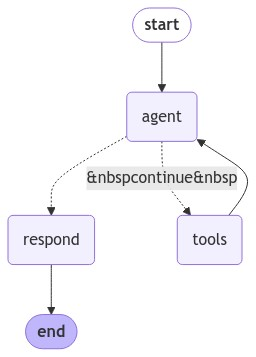

In [30]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [35]:
results = graph.invoke(input={"messages": [("human", "what's the weather in SF?")]})

In [41]:
results['messages'][-1].tool_calls

[{'name': 'WeatherResponse',
  'args': {'temperature': 75, 'wind_directon': 'South-East', 'wind_speed': 3},
  'id': 'call_bjDPgQiypQ1XlkympYzr0frk',
  'type': 'tool_call'}]

In [47]:
results['messages'][0]

HumanMessage(content="what's the weather in SF?", id='7bc3a8f4-f3ef-4ce3-8cca-f6b002addfe3')

In [48]:
results['messages'][1]

AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_Wlkt5oO1snqiL1T6Ikh3LKgA', 'function': {'arguments': '{"city":"sf"}', 'name': 'get_weather'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 12, 'prompt_tokens': 122, 'total_tokens': 134, 'completion_tokens_details': {'reasoning_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'finish_reason': 'stop', 'logprobs': None}, id='run-e1c46792-7b9f-4d00-af6e-8c1c929b380f-0', tool_calls=[{'name': 'get_weather', 'args': {'city': 'sf'}, 'id': 'call_Wlkt5oO1snqiL1T6Ikh3LKgA', 'type': 'tool_call'}], usage_metadata={'input_tokens': 122, 'output_tokens': 12, 'total_tokens': 134})

In [59]:
results['messages'][1].additional_kwargs['tool_calls']

[{'id': 'call_Wlkt5oO1snqiL1T6Ikh3LKgA',
  'function': {'arguments': '{"city":"sf"}', 'name': 'get_weather'},
  'type': 'function'}]

In [62]:
results['messages'][2]

ToolMessage(content='It is 75 degrees and sunny in SF, with 3 mph winds in the South-East direction', name='get_weather', id='8daa53c9-3c7f-4739-86ae-c6f3636f765f', tool_call_id='call_Wlkt5oO1snqiL1T6Ikh3LKgA')

In [50]:
results['messages'][3]

AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_bjDPgQiypQ1XlkympYzr0frk', 'function': {'arguments': '{"temperature":75,"wind_directon":"South-East","wind_speed":3}', 'name': 'WeatherResponse'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 25, 'prompt_tokens': 164, 'total_tokens': 189, 'completion_tokens_details': {'reasoning_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'finish_reason': 'stop', 'logprobs': None}, id='run-b79bf130-ba9e-46c3-8855-204135330107-0', tool_calls=[{'name': 'WeatherResponse', 'args': {'temperature': 75, 'wind_directon': 'South-East', 'wind_speed': 3}, 'id': 'call_bjDPgQiypQ1XlkympYzr0frk', 'type': 'tool_call'}], usage_metadata={'input_tokens': 164, 'output_tokens': 25, 'total_tokens': 189})